In [488]:
# from moo_utils import read_data
import numpy as np  
from rdkit import Chem
import rdkit.Chem.rdMolDescriptors as rdmd
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from torch.utils.data import Dataset, DataLoader
import csv
from pathlib import Path
from sklearn.decomposition import PCA 

def read_data(path, smiles_col, data_cols):
    reader = csv.reader(open(Path(path)))
    data = {}
    for row in reader: 
        try: 
            key = row[smiles_col]
            val = []
            for col in data_cols:
                val.append(float(row[col]))
            data[key]=val
            data[key][0] = -data[key][0] # to make it negative
        except:
            pass
    return data

In [489]:
# import data 
data = read_data('data/selectivity_data.csv', 0, [1,2])
ys = np.array(list(data.values()))
y0 = ys[:,0]
y1 = ys[:,1]
smiles = list(data.keys())


In [490]:
# featurize smiles, smiles to fingerprints 
length = 2048
radius = 2

mols = [Chem.MolFromSmiles(smi) for smi in smiles]
fps = [rdmd.GetMorganFingerprintAsBitVect(
            mol, radius=radius, nBits=length, useChirality=True
        ) for mol in mols]



In [491]:
fps = np.array(fps)
print(fps.shape)

(9998, 2048)


In [492]:
# split data 
train_val_size = 800
test_size = 1-(train_val_size/10000)
print(test_size)
X_train_val, X_test, train_val_truth, test_truth = train_test_split(fps,ys,test_size=test_size,random_state=4) 
X_train, X_val, train_truth, val_truth = train_test_split(X_train_val,train_val_truth,test_size=0.2,random_state=4) 
print(type(X_train))
print(X_train.shape)



0.92
<class 'numpy.ndarray'>
(639, 2048)


In [493]:
# PCA on training set 
n_components = 600
pca = PCA(n_components=n_components, svd_solver='full')
pca.fit(X_train)
print(sum(pca.explained_variance_ratio_))
P = pca.components_.transpose()
print(P.shape)

X_train_PCA = np.matmul(X_train, P)
X_val_PCA = np.matmul(X_val, P)
X_test_PCA = np.matmul(X_test, P)
print(X_train_PCA.shape)

y0_train = train_truth[:,0]
y1_train = train_truth[:,1]

0.9967493206227592
(2048, 600)
(639, 600)


In [494]:
# define datasets and optimizers
class fpDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.Tensor(np.array(X))  # store X as a pytorch Tensor
        self.y = torch.Tensor(np.array(y))  # store y as a pytorch Tensor
        self.len=len(self.X)                # number of samples in the data 

    def __getitem__(self, index):
        return self.X[index], self.y[index] # get the appropriate item

    def __len__(self):
        return self.len

train_data_0 = fpDataset(X_train,train_truth[:,0])
val_data_0 = fpDataset(X_val,val_truth[:,0])

batch_size = 100; 
train_dataloader0 = DataLoader(train_data_0, batch_size=batch_size, shuffle=True)
val_dataloader0 = DataLoader(val_data_0, batch_size=batch_size, shuffle=True)

train_data_1 = fpDataset(X_train_PCA,train_truth[:,0])
val_data_1 = fpDataset(X_val_PCA,val_truth[:,0]) 
train_dataloader1 = DataLoader(train_data_1, batch_size=batch_size, shuffle=True)
val_dataloader1 = DataLoader(val_data_1, batch_size=batch_size, shuffle=True)


# train_data_1 = fpDataset(X_train,train_truth[:,1])
# val_data_1 = fpDataset(X_val,val_truth[:,1])
# train_dataloader1 = DataLoader(train_data_1, batch_size=batch_size, shuffle=True)
# val_dataloader1 = DataLoader(val_data_1, batch_size=batch_size, shuffle=True)


In [495]:
class fp_to_score_MLP(torch.nn.Module):
    def __init__(self, input_len):
        # You can modify this method to pass hyperparameters above, but this is not necessary
        # since we already have fixed hyperparameters
        super().__init__()
        
        # Implement your code here
        self.model = torch.nn.Sequential(
        torch.nn.Linear(input_len,100),
        torch.nn.ReLU(),
        torch.nn.Linear(100, 100),
        torch.nn.ReLU(),
        torch.nn.Linear(100, 1),
        )
        
    def forward(self, x):
        x = self.model(x)
        
        return x

In [496]:
def train(model, dataloader, optimizer, device):

    epoch_loss = []
    model.train() # Set model to training mode 
    
    for batch in dataloader:    
        X, y = batch
        X = X.to(device)
        y = y.to(device)
        
        # train your model on each batch here 
        y_pred = model(X)
        
        loss = torch.nn.functional.mse_loss(y_pred.ravel(),y.ravel())
        epoch_loss.append(loss.item())
        
        # run backpropagation given the loss you defined
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return np.array(epoch_loss).mean()


def validate(model, dataloader, device):
    
    val_loss = []
    model.eval() # Set model to evaluation mode 
    with torch.no_grad():    
        for batch in dataloader:
            X, y = batch
            X = X.to(device)
            y = y.to(device)
            
            # validate your model on each batch here 
            y_pred = model(X)

            loss = torch.nn.functional.mse_loss(y_pred.ravel(),y.ravel())
            val_loss.append(loss.item())
            
    return np.array(val_loss).mean()

########### Code #############

In [497]:
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(1))

True
NVIDIA GeForce RTX 3090


In [498]:
device = 'cuda:1'
model0 = fp_to_score_MLP(2048).to(device)
model1 = fp_to_score_MLP(n_components).to(device)
# model1 = fp_to_score_MLP().to(device)

opt0 = torch.optim.Adam(model0.parameters(),lr=1e-3)
opt1 = torch.optim.Adam(model1.parameters(),lr=1e-3)

In [499]:
def run_training(model, train_dataloader, val_dataloader, optimizer):
    val_loss_curve = []
    train_loss_curve = []   
    for epoch in range(25):
        
        # Compute train your model on training data
        epoch_loss = train(model, train_dataloader, optimizer,  device=device)
        
        # Validate your on validation data 
        val_loss = validate(model, val_dataloader, device=device) 
        
        # Record train and loss performance 
        train_loss_curve.append(epoch_loss)
        val_loss_curve.append(val_loss)
        
        # print(epoch, epoch_loss, val_loss)
    return train_loss_curve, val_loss_curve




In [500]:
# print("epoch", "train loss", "validation loss")
curves0 = run_training(model0, train_dataloader0, val_dataloader0, opt0)

In [501]:
# print("epoch", "train loss", "validation loss")
curves1 = run_training(model1, train_dataloader1, val_dataloader1, opt1)

Text(0.5, 1.0, 'Model 1')

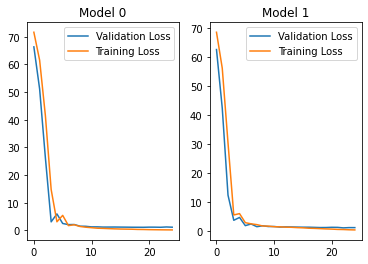

In [502]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,2)
ax[0].plot(curves0[1],label='Validation Loss')
ax[0].plot(curves0[0],label='Training Loss')
ax[0].legend()
ax[0].set_title('Model 0')

ax[1].plot(curves1[1],label='Validation Loss')
ax[1].plot(curves1[0],label='Training Loss')
ax[1].legend()
ax[1].set_title('Model 1')


In [503]:
# test data performance 
pred_0 = np.array([model0(torch.Tensor(X).to(device)).cpu().detach().numpy() for X in X_test]).squeeze()
# pred_1 = np.array([model1(torch.Tensor(X).to(device)).cpu().detach().numpy() for X in X_test]).squeeze()
pred_1 = np.array([model1(torch.Tensor(X).to(device)).cpu().detach().numpy() for X in X_test_PCA]).squeeze()

In [504]:
print(test_truth[:,0].shape)
print(pred_0.shape)
print(pred_1.shape)

(9199,)
(9199,)
(9199,)


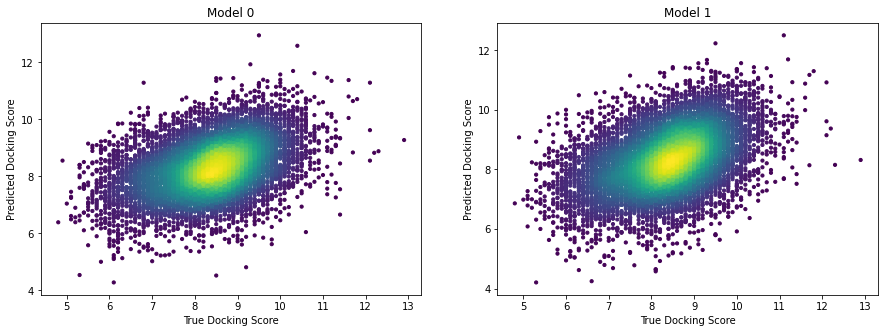

In [505]:
from scipy.stats import gaussian_kde

xy = np.vstack([test_truth[:,0], pred_0])
z = gaussian_kde(xy)(xy)

fig, ax = plt.subplots(1,2, figsize = (15,5))
ax[0].scatter(test_truth[:,0], pred_0, c=z, s=10, )
ax[0].set_xlabel('True Docking Score')
ax[0].set_ylabel('Predicted Docking Score')
ax[0].set_title('Model 0')

# xy = np.vstack([test_truth[:,1], pred_1])
xy = np.vstack([test_truth[:,0], pred_1])
z = gaussian_kde(xy)(xy)
ax[1].scatter(test_truth[:,0], pred_1, c=z, s=10, )
ax[1].set_xlabel('True Docking Score')
ax[1].set_ylabel('Predicted Docking Score')
ax[1].set_title('Model 1')
plt.show()

In [506]:
# show metrics 

# test performance performance 
print('Model 0')
print('MSE: ' + str(mean_squared_error(test_truth[:,0], pred_0)))

print('Model 1')
print('MSE: ' + str(mean_squared_error(test_truth[:,0], pred_1)))

Model 0
MSE: 1.2533964208619854
Model 1
MSE: 1.3087448443630214
